In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [2]:
%cd HanabiNN

/content/gdrive/My Drive/HanabiNN


In [3]:
!pip install nptyping

In [4]:
import os
from typing import List
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import IPython

from Game import (
    DGAME,
    DTYPE,
    play_game,
    train,
    save,
    plot,
    score,
)
from Game import (
    LIFES,
    HINTS,
    DISCARDED,
    PLAYERS,
    DPLAYER,
    DTILE,
    HAND_SIZE,
    DHANDTILE,
    PILES,
    LAST_ROUND,
    MAX_ACTION,
)



In [5]:
NAME: str = "Initialization"

SEED = 12345678
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

MEMORY_SIZE: int = 10 ** 4
N_NEW_GAMES: int = 500
N_OLD_GAMES: int = 1000
EPSILON: float = 1
GAMMA: float = 0.5



In [6]:
INPUT: List[int] = (
    LIFES
    + HINTS
    + list(DISCARDED)
    + [
        PLAYERS[:DPLAYER][t * DHANDTILE + DTILE + i]
        for t in range(HAND_SIZE)
        for i in range(DHANDTILE - DTILE)
    ]
    + list(PLAYERS[DPLAYER:])
    + list(PILES)
    + LAST_ROUND
)



Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 217)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               111616    
_________________________________________________________________
p_re_lu (PReLU)              (None, 512)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 512)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 38)                19494     
Total params: 394,790
Trainable params: 394,790
Non-trainable params: 0
________________________________________________

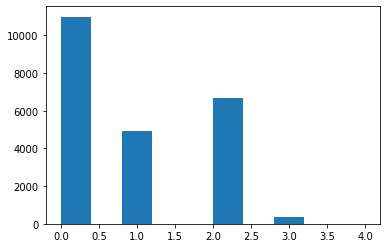

In [7]:
if os.path.exists(os.path.join(NAME, "nn")):
    model = tf.keras.models.load_model(os.path.join(NAME, "nn"))
    memories = np.load(os.path.join(NAME, "memories.npy"))
    points = np.load(os.path.join(NAME, "points.npy"))
    loss = np.load(os.path.join(NAME, "loss.npy"))
    Qs = np.load(os.path.join(NAME, "Qs.npy"))
else:
    inputs = tf.keras.Input(shape=(len(INPUT),))
    hidden1 = tf.keras.layers.Dense(
        512,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-1, maxval=1
        ),
    )(inputs)
    leaky1 = tf.keras.layers.PReLU()(hidden1)
    hidden2 = tf.keras.layers.Dense(
        512,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=1, maxval=1
        ),
    )(leaky1)
    leaky2 = tf.keras.layers.PReLU()(hidden2)
    Q = tf.keras.layers.Dense(
        MAX_ACTION,
        activation="linear",
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=1, maxval=1
        ),
    )(leaky2)
    model = tf.keras.Model(inputs=inputs, outputs=Q)
    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, momentum=0.95),
    )
    model.summary()

    if os.path.exists(os.path.join(NAME, "memories_t0.csv")):
        memories = np.loadtxt(os.path.join(NAME, "memories_t0.csv"), dtype=DTYPE)
    elif os.path.exists(os.path.join(NAME, "memories_t0.npy")):
        memories = np.load(os.path.join(NAME, "memories_t0.npy"))
    else:
        # CREATE MEMORIES DB
        memories = np.empty((0, DGAME), dtype=DTYPE)
        i = 1
        while memories.shape[0] < MEMORY_SIZE:
            print("Create memories, round ", i)
            memories, _ = play_game(
                EPSILON,
                MEMORY_SIZE,
                N_NEW_GAMES,
                N_OLD_GAMES,
                memories,
                np.empty((0, 4)),
                model,
                INPUT,
                sample_memories=False,
            )
            i += 1

        MEMORY_SIZE = 10 ** 5

        for j in range(i - 1):
            print("Improve memories, round ", j + 1, " of ", i - 1)
            memories, _ = play_game(
                EPSILON,
                MEMORY_SIZE,
                N_NEW_GAMES,
                N_OLD_GAMES,
                memories,
                np.empty((0, 4)),
                model,
                INPUT,
                sample_memories=False,
            )

        points = np.empty((0, 4))
        loss = np.empty((0, 1))
        Qs = np.empty((0, 4))

        save(memories, points, loss, model, Qs, NAME, first=True)

        plt.hist(np.apply_along_axis(score, 1, memories))
        plt.savefig(os.path.join(NAME, "score_memories_t0.png"))

    points = np.empty((0, 4))
    loss = np.empty((0, 1))

    print("Train with gamma=0")
    loss = train(0, memories, loss, model, INPUT, patience=100)
    print("Train with final gamma")
    loss = train(GAMMA, memories, loss, model, INPUT, patience=100)

    save(memories, points, loss, model, Qs, NAME, first=True)

    points = np.empty((0, 4))
    loss = np.empty((0, 1))
    Qs = np.empty((0, 4))



In [8]:
MEMORY_SIZE = 10 ** 4
N_NEW_GAMES = 50
N_OLD_GAMES = 100
N_EPISODES: int = 50



Episode:  52
epsilon:  -0.020000000000000018
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 2 2 2 3 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 2 3 2
 2 3 2 2 2 3 2 3 2 2 2 3 3 2 2 2 3 2 2 3 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 2 2]
Epoch 1/5000
327/327 [==============================] - 2s 6ms/step - loss: 54321651712.0000
Epoch 2/5000
327/327 [==============================] - 2s 6ms/step - loss: 53773955072.0000
Epoch 3/5000
327/327 [==============================] - 2s 6ms/step - loss: 149759672320.0000
Epoch 4/5000
327/327 [==============================] - 2s 6ms/step - loss: 1066847616.0000
Epoch 5/5000
327/327 [==============================] - 2s 6ms/step - loss: 127410536448.0000
Epoch 6/5000
327/327 [==============================] - 2s 6ms/step - loss: 83607011328.0000
Epoch 7/5000
327/327 [==============================] - 2s 6ms/step - loss: 72274444288.00

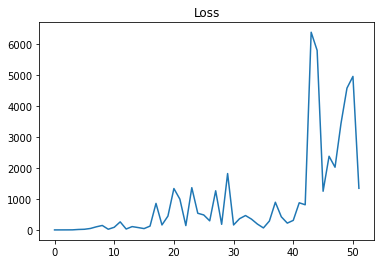

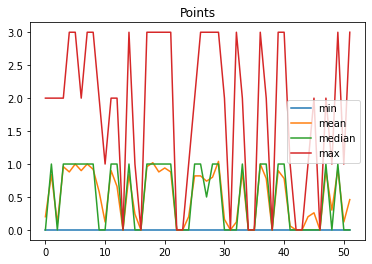

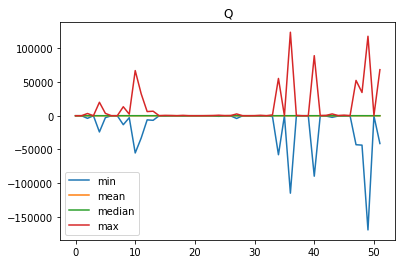

In [11]:
e = 0

while e < N_EPISODES:

    e = len(points)

    print("Episode: ", e + 1)
    EPSILON = 1 - e / N_EPISODES
    print("epsilon: ", EPSILON)

    memories, _ = play_game(
        EPSILON,
        MEMORY_SIZE,
        N_NEW_GAMES,
        N_OLD_GAMES,
        memories,
        np.empty((0, 4)),
        model,
        INPUT,
    )

    loss = train(GAMMA, memories, loss, model, INPUT, name=NAME, patience=100)

    print("Testing")
    _, points = play_game(
        0,
        MEMORY_SIZE,
        N_NEW_GAMES,
        0,
        np.empty((0, DGAME), dtype=DTYPE),
        points,
        model,
        INPUT,
    )

    pred = model.predict(memories[:, INPUT], batch_size=512)

    Qs = np.vstack(
        (Qs, np.array([np.amin(pred), np.mean(pred), np.median(pred), np.max(pred)]))
    )

    save(memories, points, loss, model, Qs, NAME)
    plot(loss, points, Qs, NAME)

    IPython.display.clear_output(wait=True)



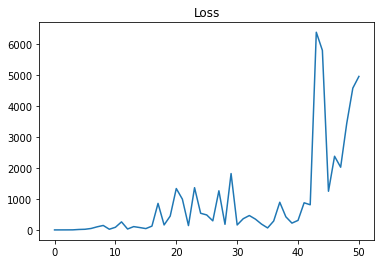

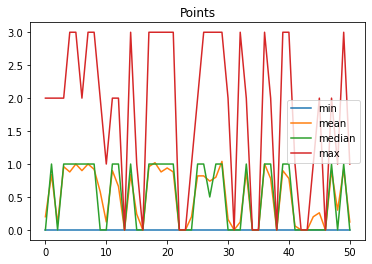

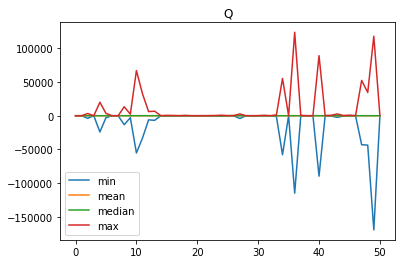

In [10]:
save(memories, points, loss, model, Qs, NAME, last=True)
plot(loss, points, Qs, NAME)
